### Examine weighted spatial fetalization and all disease DEGs for the Kuppe dataset, and then calculate proportion of fetalization spots and Moran's I 

- Does processing specifically for the format of Kuppe dataset

The authors already performed `cell2location`, so we will use the fetal + disease up DEGs (fetal reactivation genes) to calculate a cell-type specific activity score and then multiply it by the cell type proportion

In [1]:
import scanpy as sc 
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from libpysal.weights import KNN
from esda.moran import Moran

In [2]:
adata_list_dir = "../processed_data/"

In [3]:
adata_files = [f for f in os.listdir(adata_list_dir) if f.endswith(".h5ad") and ".ipynb_checkpoints" not in f]
adata_sample_names = [adata.replace(".h5ad", "") for adata in adata_files]

In [4]:
def preprocess_spatial(adata):
    '''Preprocess the Kuppe spatial adata files'''
    
    # store the raw counts
    adata.layers['counts'] = adata.X

    # log normalize the counts
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

    # spatial coordinates are here: adata.obsm['X_spatial']
    return adata

In [5]:
def identify_significant_up_DEGs(deseq2_results_path):
    '''Extract the significant DEGs'''
    deseq2_results_df = pd.read_csv(deseq2_results_path, index_col = 0)
    sig_genes =  deseq2_results_df.loc[(deseq2_results_df['significant'] == True) & (deseq2_results_df['log2FoldChange'] > 0), ]
    sig_genes_list = list(sig_genes.index)
    return(sig_genes_list)

In [6]:
def obtain_fetalization_score(adata, fetalization_gene_list, score_name):
    '''Calculate the gene score for a list of fetalization genes'''
    sc.tl.score_genes(adata, fetalization_gene_list, score_name=score_name)
    return(adata)

In [7]:
def visualize_fetalization(adata, score_name):
    '''Visualize the fetalization score (score_name) for Kuppe adata'''

    fig, ax = plt.subplots()

    with plt.rc_context():
        sc.pl.spatial(
        adata,
        color=[score_name],  
        img_key="hires",  
        spot_size = 0.0175, 
        size=1.3,
        cmap = 'magma',
        alpha_img=0.6, edges_width=0.01,
        title="Expression of " + score_name, 
        vmax=-1, vmin = 1,
        ax = ax, show = False)

    return fig

#### Examine only the more common cell types that have `cell2location` values already, and which display the fetalization signature (exclude Mast cells and Adipocytes)

In [17]:
cell_types = ["Cardiomyocyte", "Endothelial", "Fibroblast", "Myeloid", "Lymphoid", "Neuronal", "Pericyte", "vSMC"]

# we will focus only on "UP" genes for this analysis
directions = ["up", "down"]

# specify directory with fetalization genes
fetalization_gene_dir = "../../../aggregated_analysis/pseudobulked_analysis/pydeseq2/fetalization_genes/" 
disease_genes_dir = "../../../aggregated_analysis/pseudobulked_analysis/pydeseq2/pydeseq2_results/"

#### Create directory to save plots

In [9]:
adata_fetalization_dir = "adata_with_weighted_fetalization_scores/"
os.makedirs(adata_fetalization_dir, exist_ok=True)

### Test for one sample

In [10]:
adata = sc.read_h5ad("../processed_data/Visium_FZ_GT_P4.h5ad")

In [11]:
adata = preprocess_spatial(adata)
# rename one of the cell types 
adata.obs = adata.obs.rename(columns = {'vSMCs': 'vSMC'})

In [12]:
adata.obs.columns

Index(['n_counts', 'n_genes', 'percent.mt', 'Adipocyte', 'Cardiomyocyte',
       'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal',
       'Pericyte', 'Cycling.cells', 'vSMC', 'cell_type_original',
       'assay_ontology_term_id', 'cell_type_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'ethnicity_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id'],
      dtype='object')

In [13]:
# confirm that the proportions add to one
adata.obs['total_prop'] = (adata.obs['Adipocyte']  + adata.obs['Cardiomyocyte']  + adata.obs['Endothelial'] + adata.obs['Fibroblast']  +
                          adata.obs['Lymphoid'] + adata.obs['Mast'] + adata.obs['Myeloid'] + adata.obs['Neuronal']  +
                          adata.obs['Pericyte'] + adata.obs['Cycling.cells']  + adata.obs['vSMC'] )

adata.obs['total_prop'].head()

AAACAACGAATAGTTC-1    1.0
AAACAAGTATCTCCCA-1    1.0
AAACAATCTACTAGCA-1    1.0
AAACACCAATAACTGC-1    1.0
AAACAGAGCGACTCCT-1    1.0
Name: total_prop, dtype: float64

In [14]:
direction = "up" 

for cell_type in cell_types:
    fetalization_score_name = cell_type + " fetalization: " + direction
    fetalization_gene_path = fetalization_gene_dir + cell_type + "_" + direction + "_fetalization_genes.csv" 
    df = pd.read_csv(fetalization_gene_path)
    fetalization_gene_list = list(df['0'])
    adata = obtain_fetalization_score(adata, 
                                      fetalization_gene_list = fetalization_gene_list, 
                                      score_name = fetalization_score_name)

       'SMCR2', 'NCR3LG1', 'LYPD6',
       ...
       'PTK6', 'PABPC5', 'FABP1', 'CER1', 'STOX1', 'LRRIQ3', 'VCAN-AS1',
       'CNTN4-AS2', 'ANLN', 'FBXO15'],
      dtype='object', length=212)
       'RPS6KA5', 'PPP1R26-AS1', 'ZNF730', 'QRFPR', 'ESM1', 'FAM163A',
       'LINC00504', 'B3GALT5', 'ASTN1', 'ADORA1', 'RHBDL3', 'FAM83D',
       'LINC00642', 'CLVS1', 'STK32B', 'EPHB1', 'LINC01117', 'SCML2', 'CDHR3',
       'SLC35F2', 'DCDC2C', 'BLM', 'RGS20', 'OIT3', 'LRRC36', 'SCN11A',
       'LINC00964', 'NOS2', 'TMEM200A', 'BRIP1', 'SYT17'],
      dtype='object')
       'LINC01013', 'RFPL1S', 'CYTL1',
       ...
       'PSD2', 'AJAP1', 'KCNQ5', 'DCX', 'MOV10L1', 'KHDRBS2', 'KCTD16', 'NGEF',
       'CNTN4-AS2', 'KCNK12'],
      dtype='object', length=139)
       'PLEKHG4B', 'C2orf72', 'RELN',
       ...
       'LRP1B', 'PRAME', 'RSPO3', 'PPP4R4', 'IDO2', 'SLC18A1', 'CLNK',
       'SLC6A7', 'CCL4L2', 'CACNA2D2'],
      dtype='object', length=158)
       'MEF2C-AS1', 'MIR181A1HG'],
      dtyp

In [15]:
# get sum of the products of each cell type and its corresponding fetalization value
total_fetalization = sum(adata.obs[ct] * adata.obs[f"{ct} fetalization: {direction}"] for ct in cell_types)
adata.obs['total_fetalization'] = total_fetalization

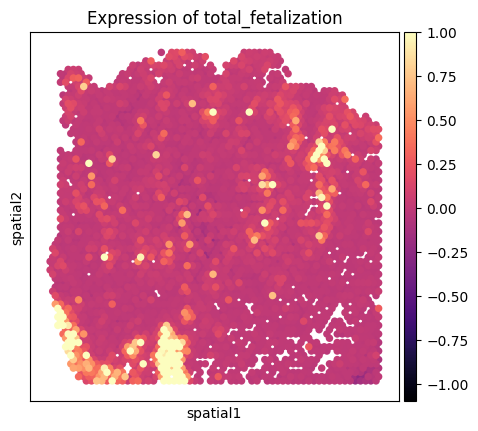

In [16]:
spatial_plot = visualize_fetalization(adata, score_name = 'total_fetalization')

### Iterate through all cell types and all samples

Visium_IZ_P10
       'NCR3LG1', 'LYPD6', 'RPL23A',
       ...
       'RPS12', 'KCNQ5', 'GALNT9', 'PTK6', 'FABP1', 'CER1', 'LRRIQ3',
       'VCAN-AS1', 'CNTN4-AS2', 'FBXO15'],
      dtype='object', length=172)
       'TEX9', 'ADAM18', 'MED12L',
       ...
       'LINC00379', 'PSG6', 'EXOC3L4', 'ERMN', 'PSG5', 'PSG2', 'POTEM',
       'TIFAB', 'COL5A1-AS1', 'ZP1'],
      dtype='object', length=584)
       'IGF2-AS', 'QRFPR', 'FAM163A', 'LINC00504', 'DLGAP1', 'B3GALT5',
       'PIEZO2', 'LINC00642', 'CLVS1', 'LINC01117', 'DCDC2C', 'RGS20', 'OIT3',
       'SCN11A', 'LINC00964', 'LOXHD1', 'TMEM200A'],
      dtype='object')
       'NPIPB11', 'FAM163A', 'LRRC3B', 'TEX9', 'CLVS1', 'PIEZO2', 'LINC00504',
       'LINC00265', 'LINC00598', 'ARPP21', 'NPIPB3', 'KCNIP1', 'DLGAP2',
       'FAM178B', 'DSCAML1', 'ZNF730', 'FGFR2', 'CACNG8', 'GRIK4', 'GABRG3',
       'EML6', 'SCN11A', 'NOS1', 'NRG3', 'LRRC55', 'CLEC4F', 'DSCAM',
       'LINC00642', 'TMEM132D', 'ACER1', 'CNTN5', 'IGF2-AS', 'GRAPL',
      

/mnt/data1/william/tmp/ipykernel_1005196/1114722730.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Visium_GT_IZ_P13
       'SMCR2', 'NCR3LG1', 'LYPD6',
       ...
       'PTK6', 'PABPC5', 'FABP1', 'CER1', 'STOX1', 'LRRIQ3', 'SCN3A',
       'VCAN-AS1', 'CNTN4-AS2', 'FBXO15'],
      dtype='object', length=208)
       'FAT3', 'SRCIN1', 'SPAM1',
       ...
       'LINC00379', 'PSG6', 'PSG5', 'PSG2', 'DBH-AS1', 'POTEM', 'CXCL6',
       'TIFAB', 'COL5A1-AS1', 'CYP4F3'],
      dtype='object', length=661)
       'RPS6KA5', 'PPP1R26-AS1', 'PROM1', 'FGF13', 'ZNF730', 'GRID1', 'QRFPR',
       'FAM163A', 'LINC00504', 'DLGAP1', 'B3GALT5', 'NMNAT2', 'ASTN1',
       'ADORA1', 'RHBDL3', 'LINC00642', 'CLVS1', 'CCNJL', 'EPHB1', 'FAM184A',
       'LINC01117', 'CDHR3', 'LRFN5', 'DCDC2C', 'PRRT2', 'RGS20', 'OIT3',
       'KCNJ3', 'LRRC36', 'SCN11A', 'NPAS3', 'LINC00964', 'LOXHD1', 'KIRREL3',
       'KCNQ3'],
      dtype='object')
       'RFX8', 'FAM184A', 'CCNJL',
       ...
       'SLC6A3', 'FGF14', 'SPTA1', 'OIT3', 'TNR', 'SLC5A4', 'FATE1', 'DCDC2C',
       'TUBB8', 'SHANK2-AS1'],
      dtype='object'

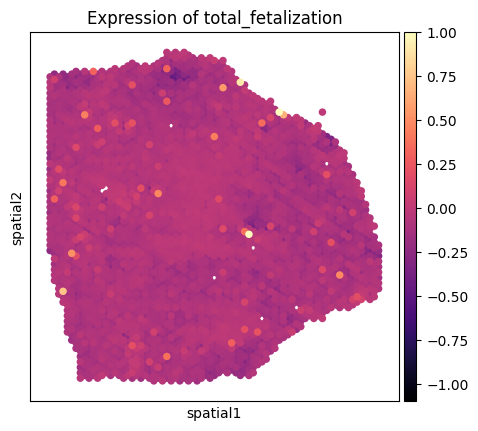

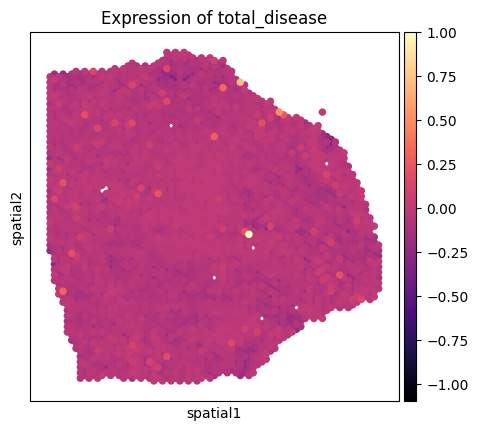

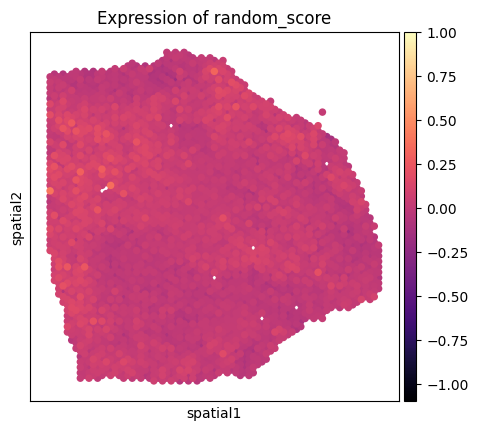

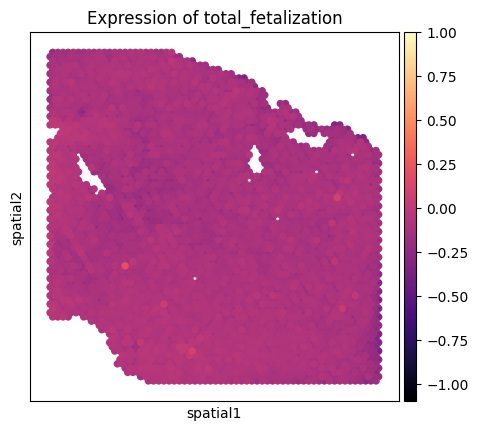

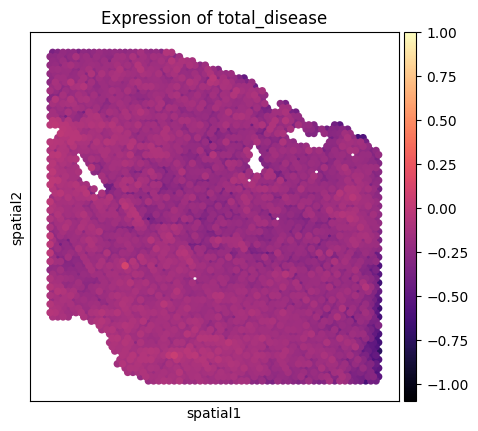

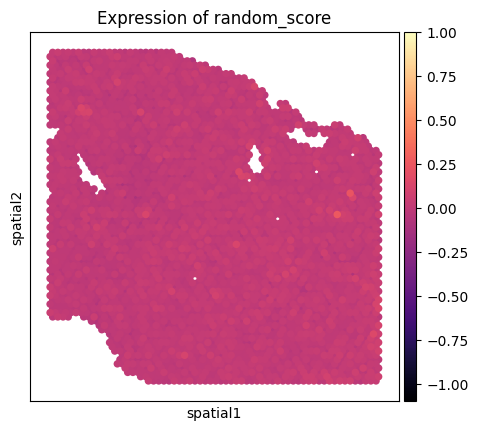

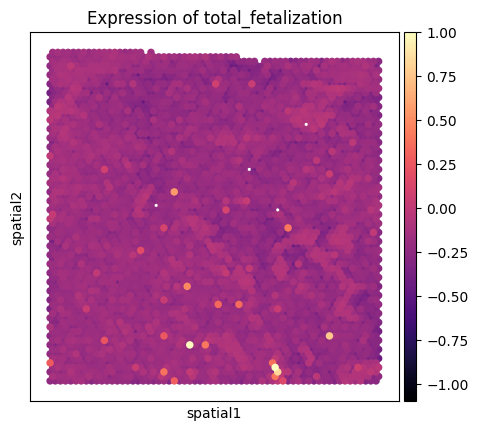

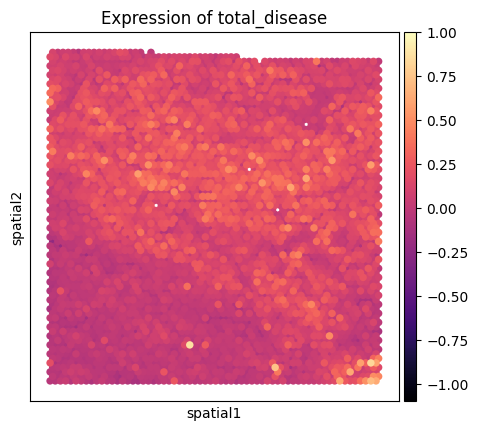

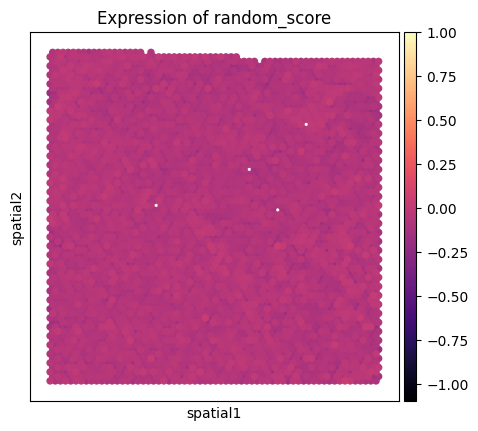

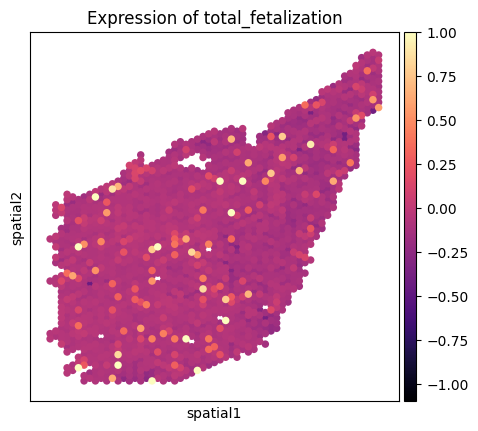

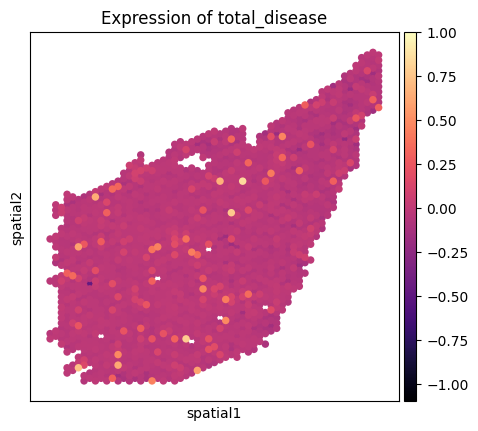

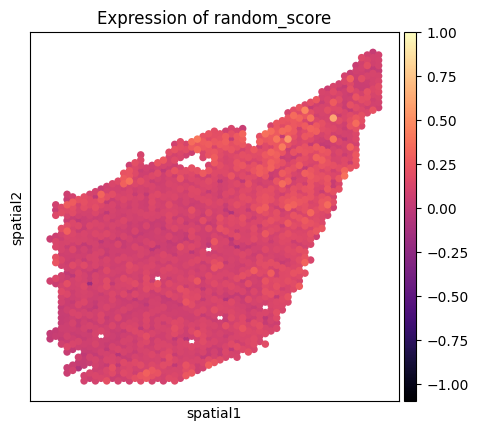

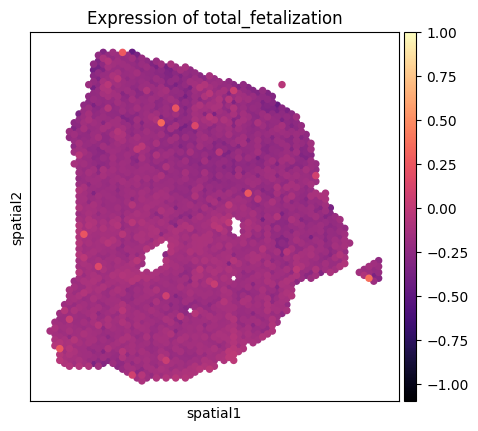

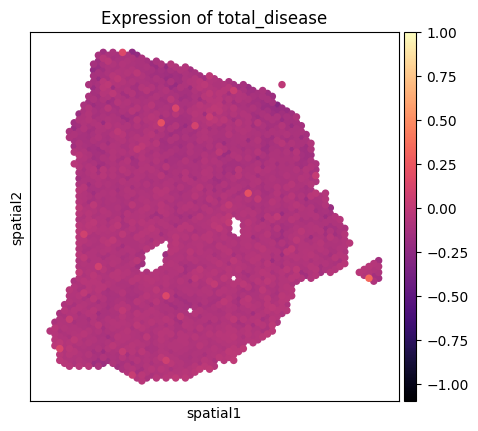

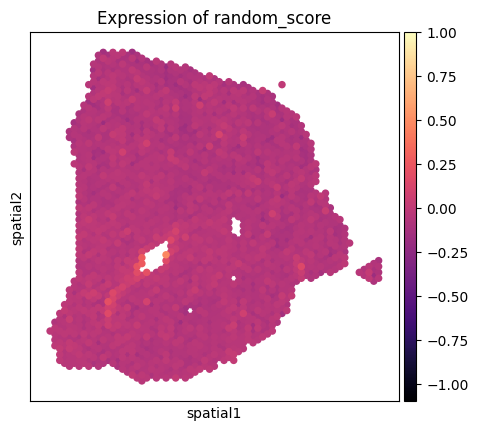

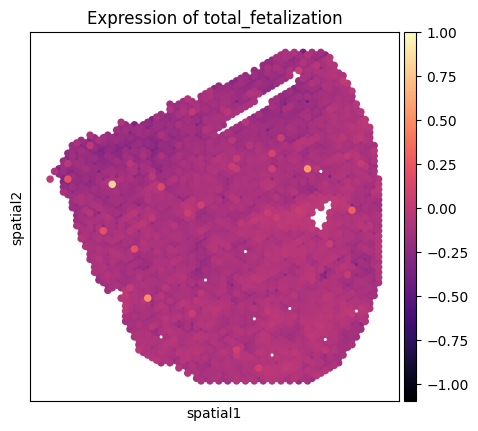

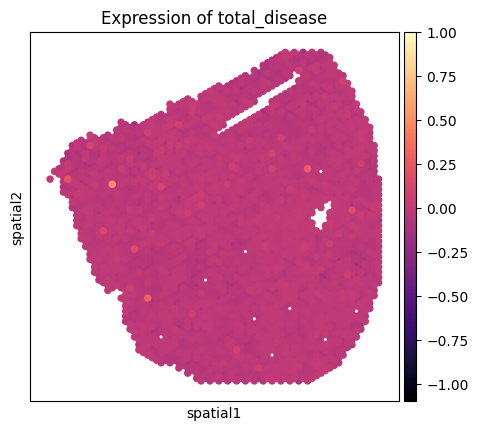

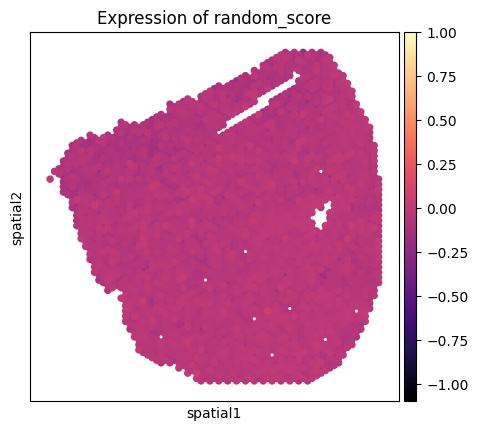

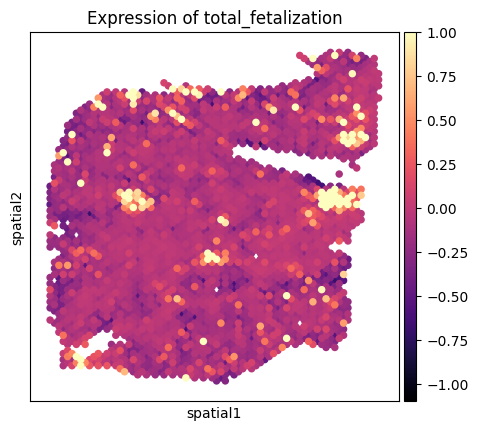

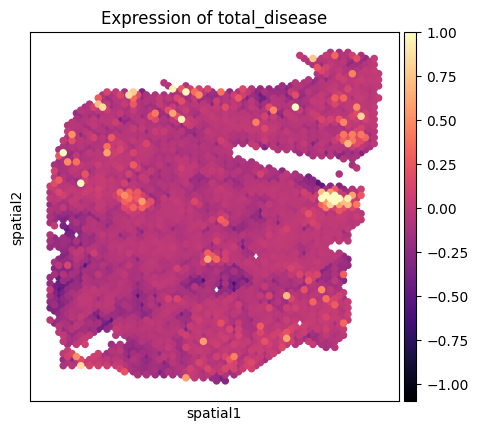

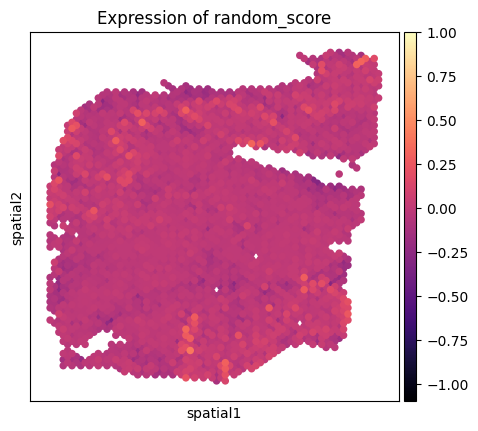

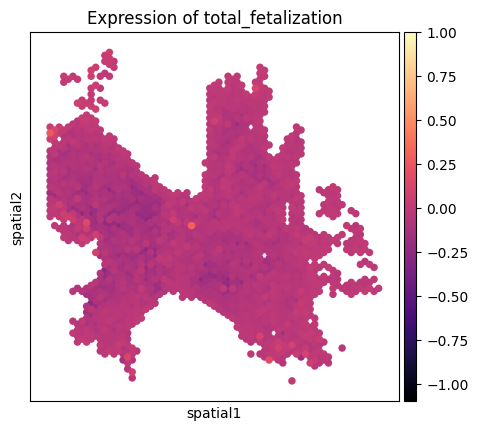

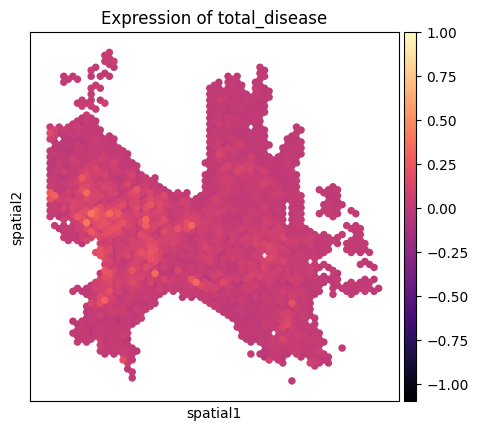

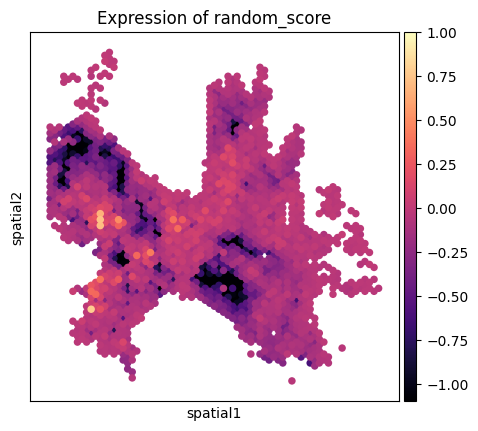

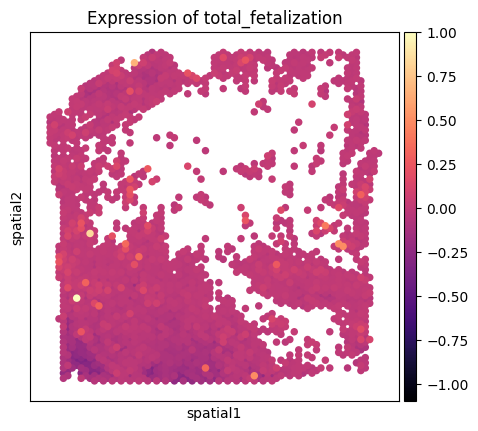

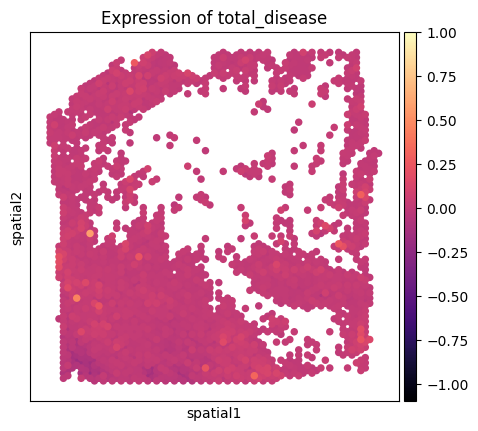

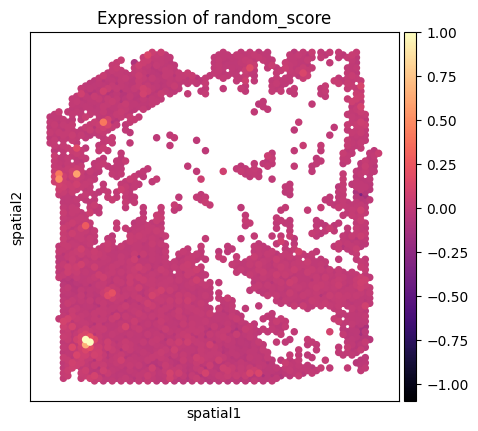

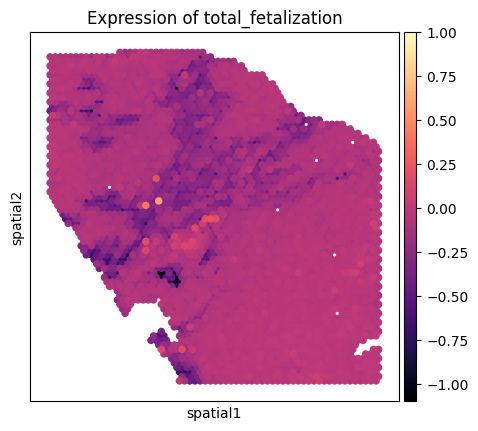

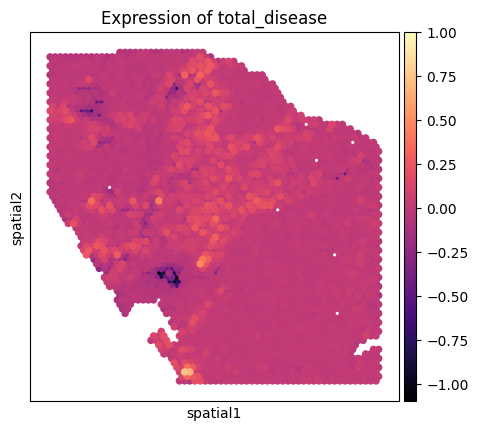

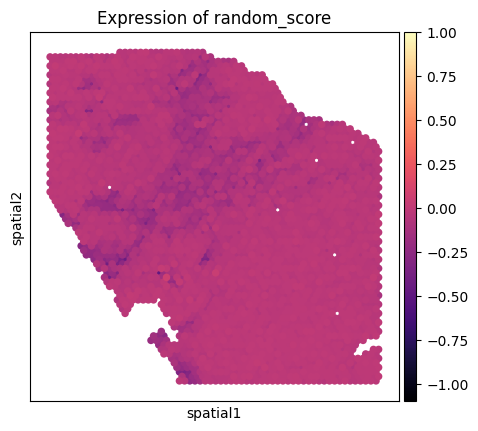

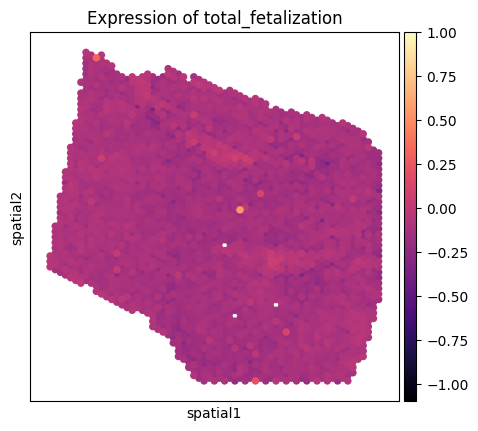

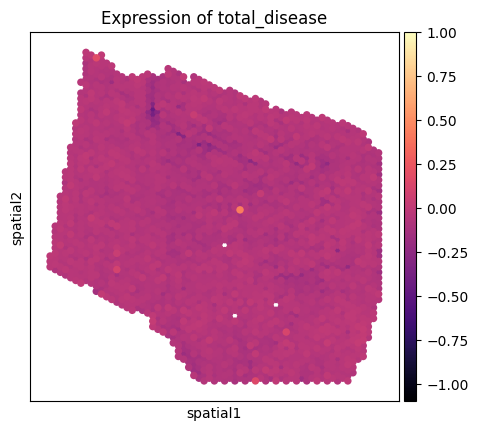

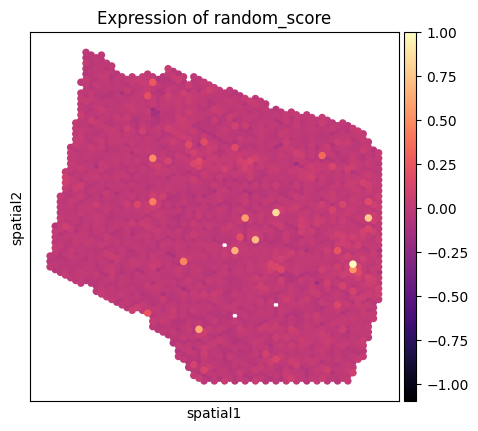

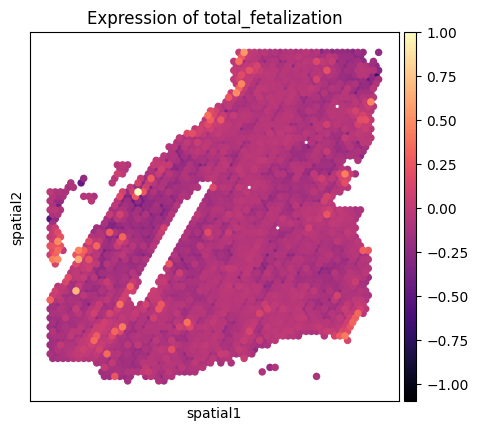

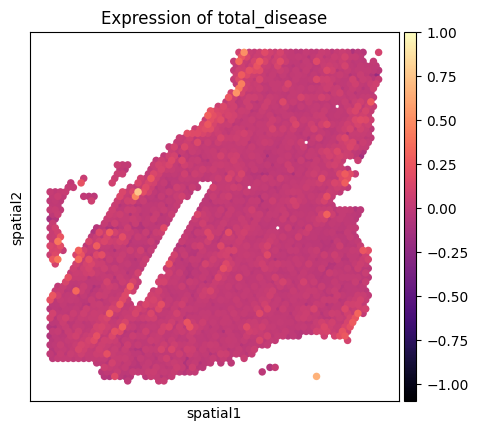

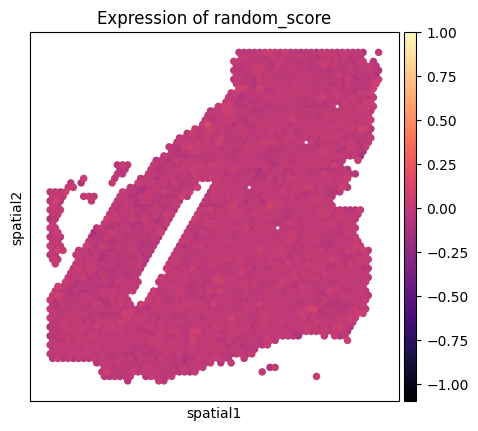

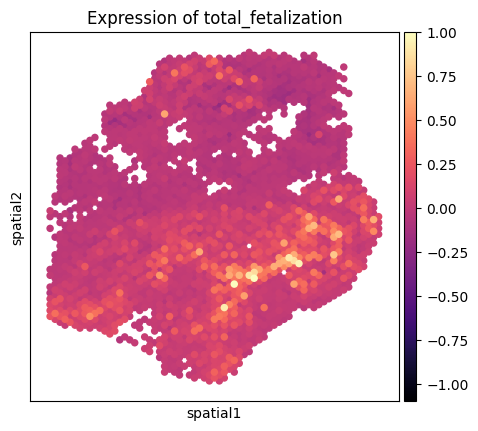

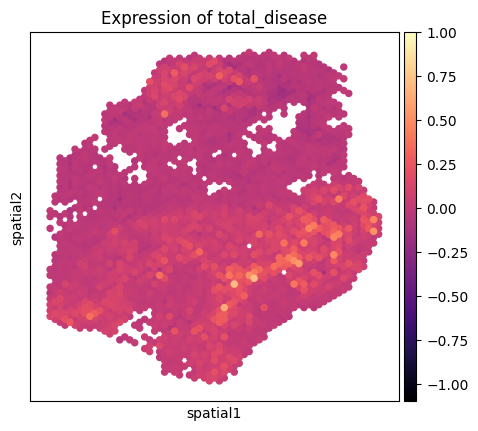

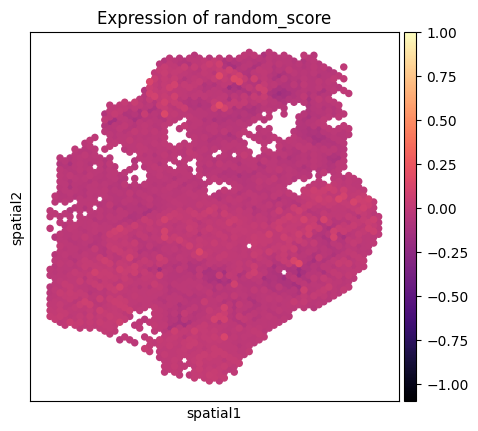

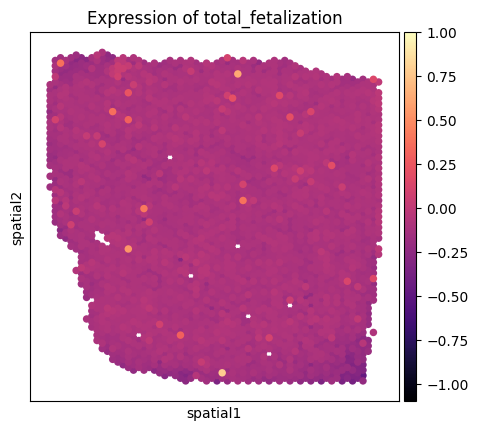

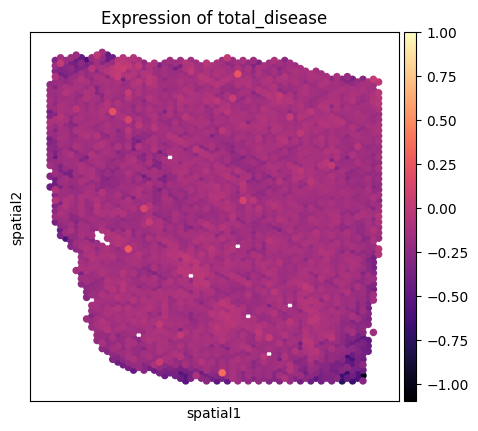

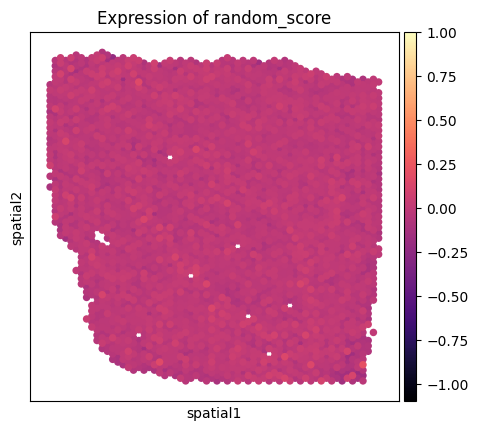

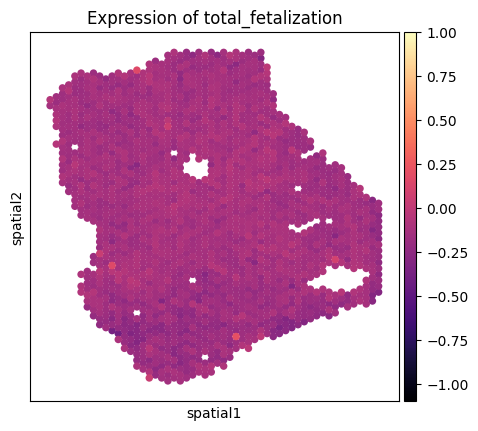

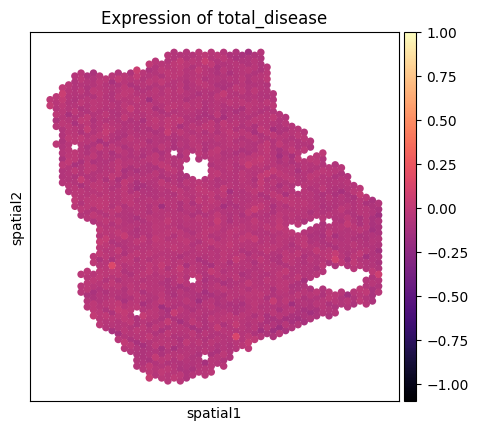

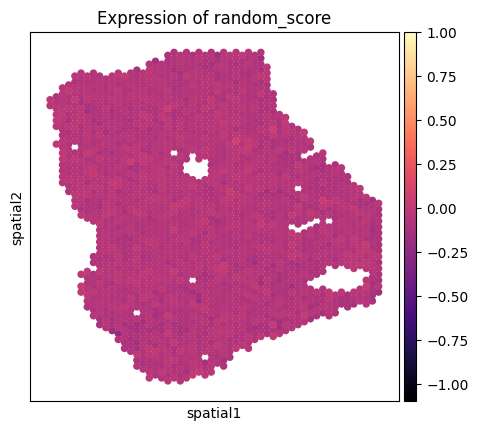

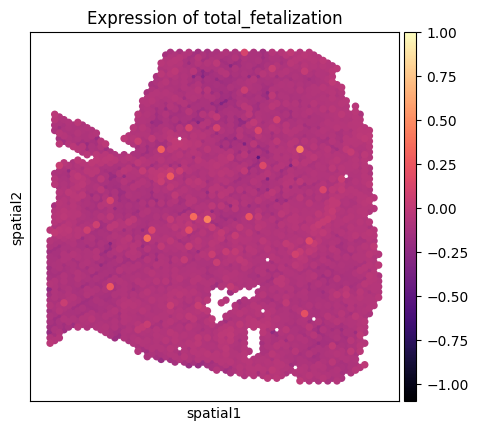

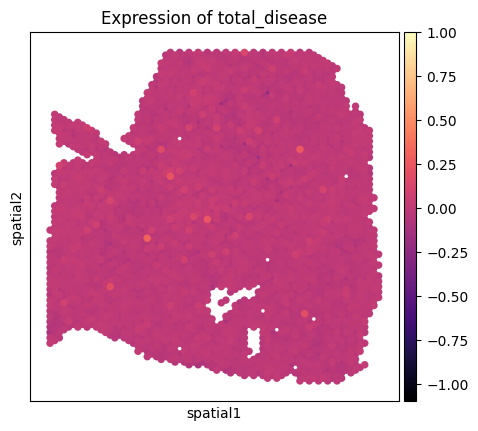

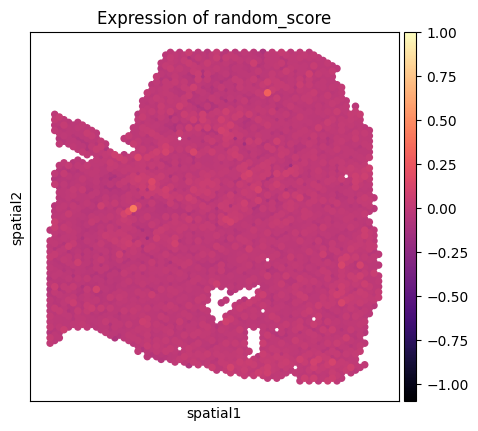

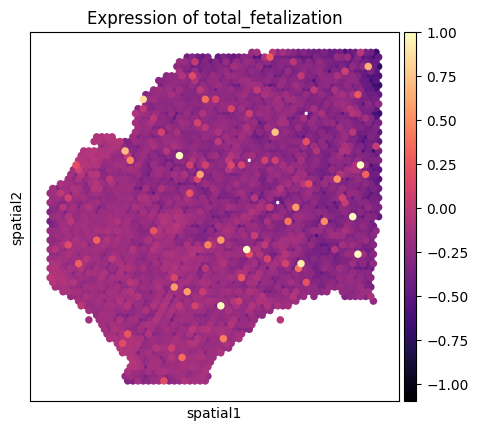

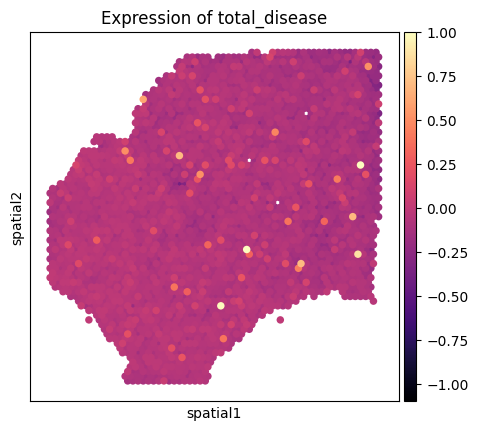

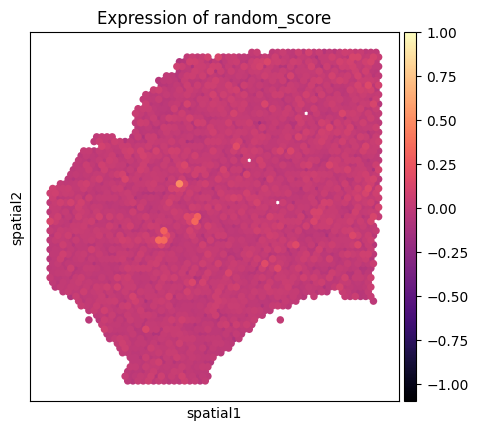

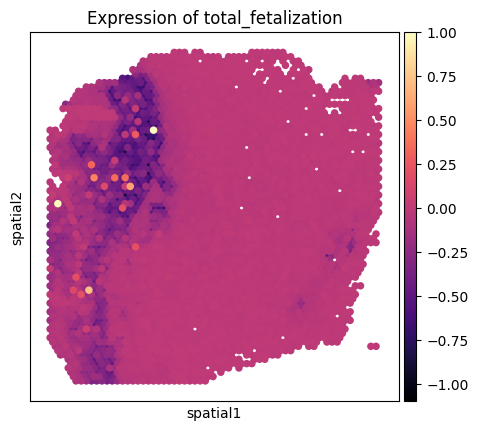

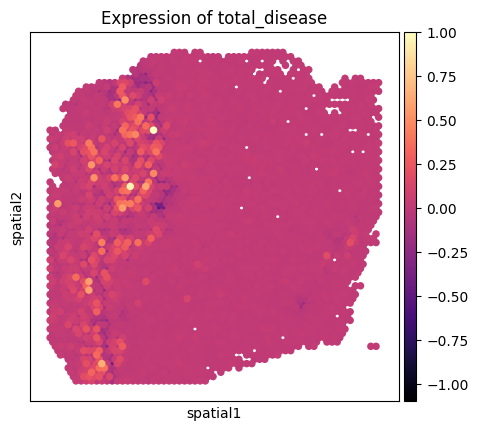

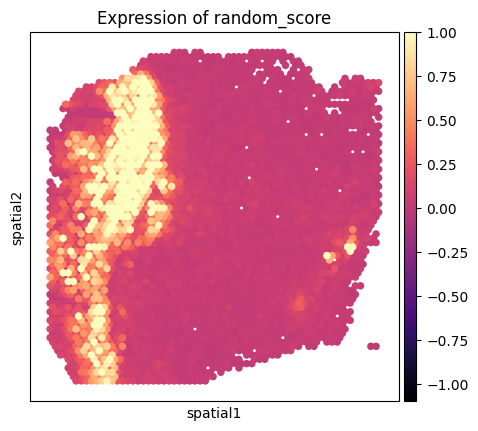

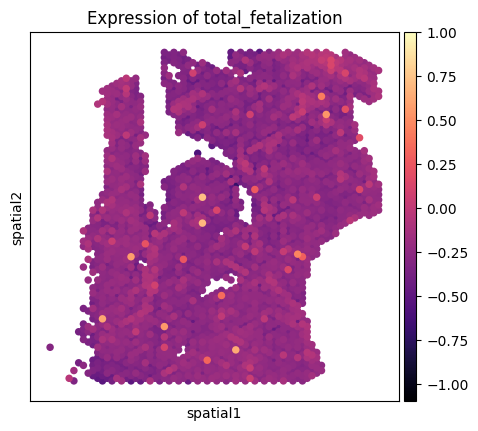

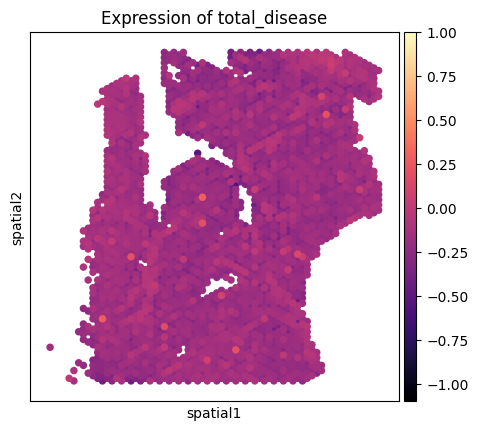

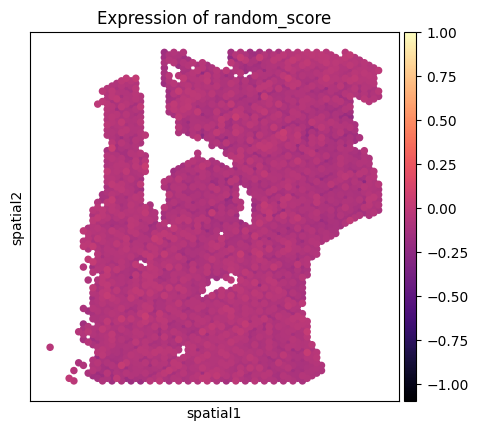

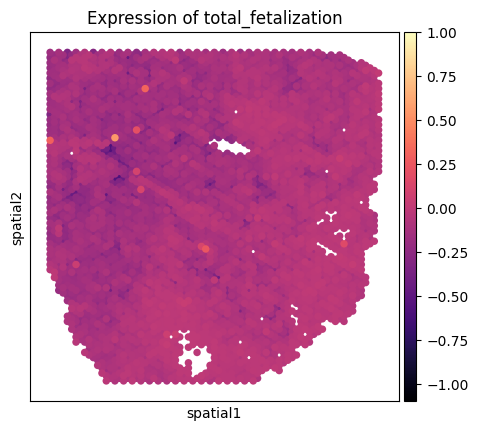

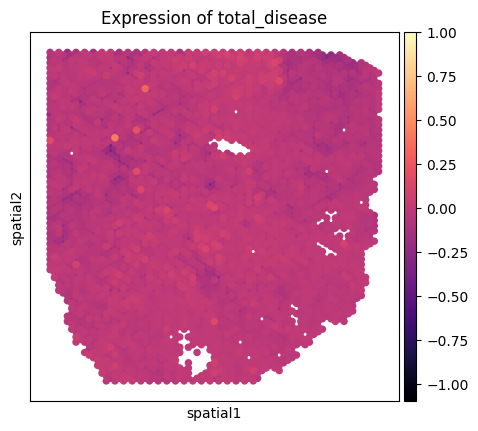

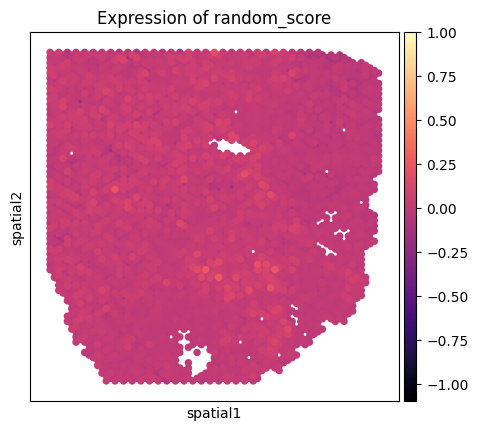

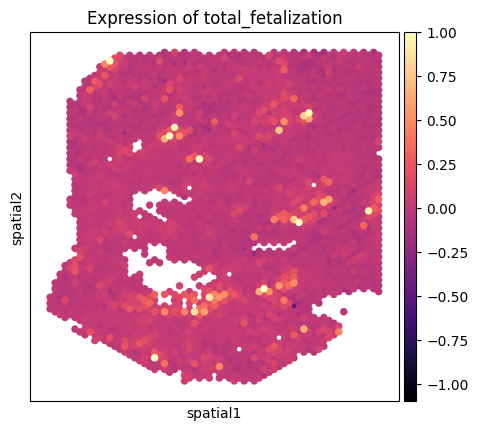

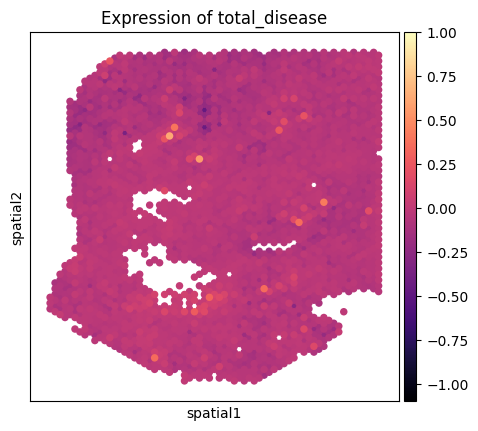

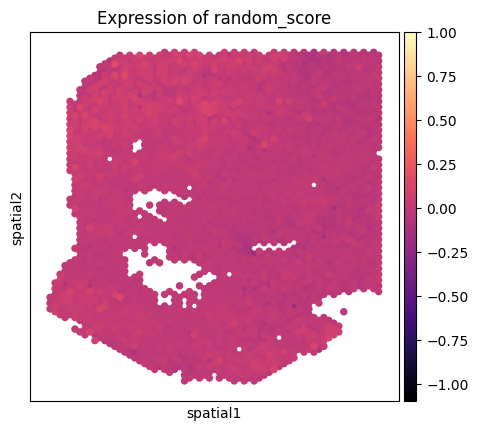

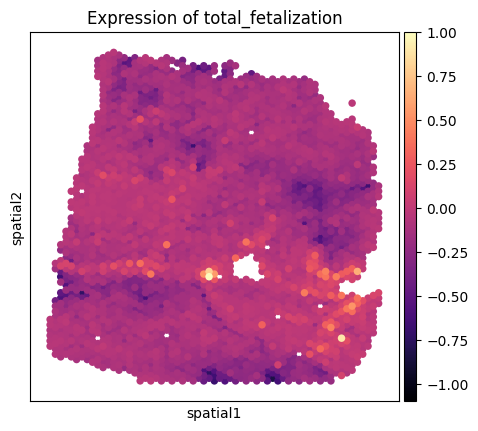

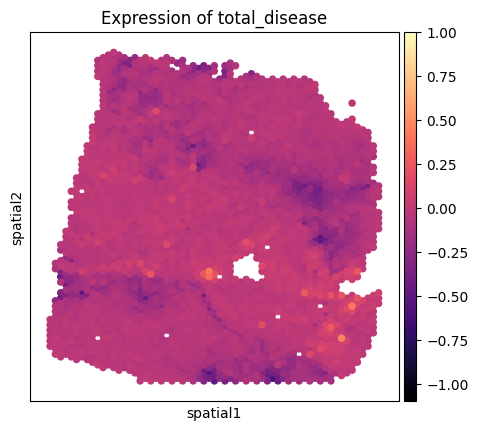

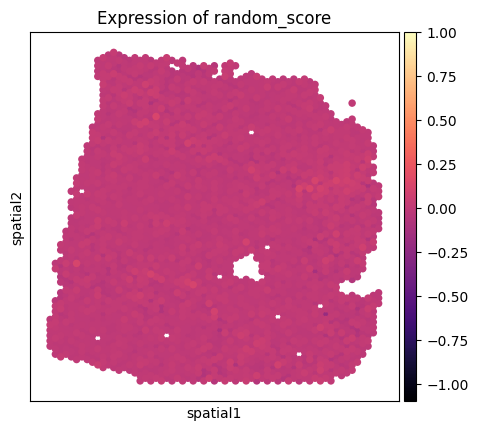

In [ ]:
%%time

plots_dir = adata_fetalization_dir + "plots/"
os.makedirs(plots_dir, exist_ok=True)

direction = "up"
total_fetalization_score = "total_fetalization"
total_disease_score = "total_disease"
random_fetalization_score = "random_score"

for adata_sample, adata_file in zip(adata_sample_names, adata_files):

    print(adata_sample, flush=True)
    adata = sc.read_h5ad(adata_list_dir + adata_file)

    adata = preprocess_spatial(adata)
    # rename one of the cell types 
    adata.obs = adata.obs.rename(columns = {'vSMCs': 'vSMC'})
    
    for cell_type in cell_types:

        # get fetalization score
        fetalization_score_name = cell_type + " fetalization: " + direction
        fetalization_gene_path = fetalization_gene_dir + cell_type + "_" + direction + "_fetalization_genes.csv" 
        df = pd.read_csv(fetalization_gene_path)
        fetalization_gene_list = list(df['0'])
        adata = obtain_fetalization_score(adata, 
                                          fetalization_gene_list = fetalization_gene_list, 
                                          score_name = fetalization_score_name)

        # get disease score
        disease_gene_path = disease_genes_dir + cell_type + "_disease-binary_Y_vs_N_results.csv"
        disease_gene_list = identify_significant_up_DEGs(disease_gene_path)
        disease_score_name = cell_type + " disease: " + direction
        adata = obtain_fetalization_score(adata, 
                                          fetalization_gene_list = disease_gene_list, 
                                          score_name = disease_score_name)
        
        # get a random gene set of equal size to the fetalization gene set
        random_features = np.random.choice(adata.var["features"], size=len(fetalization_gene_list), replace=False)
        random_score_name = cell_type + " random: " + direction
        adata = obtain_fetalization_score(adata, fetalization_gene_list=random_features, score_name = random_score_name)

    # do a second loop over to get the scores
    for cell_type in cell_types:
        # get sum of the products of each cell type and its corresponding fetalization value
        total_fetalization = sum(adata.obs[ct] * adata.obs[f"{ct} fetalization: {direction}"] for ct in cell_types)
        adata.obs[total_fetalization_score] = total_fetalization

        total_disease = sum(adata.obs[ct] * adata.obs[f"{ct} disease: {direction}"] for ct in cell_types)
        adata.obs[total_disease_score] = total_disease
        
        random_fetalization = sum(adata.obs[ct] * adata.obs[f"{ct} random: {direction}"] for ct in cell_types)
        adata.obs[random_fetalization_score] = random_fetalization

    # produce the plots
    spatial_fetalization_plot = visualize_fetalization(adata, score_name = total_fetalization_score)
    spatial_fetalization_plot.savefig(plots_dir + adata_sample + "_actual_fetalization_spatial_plot.pdf") 

    spatial_disease_plot = visualize_fetalization(adata, score_name = total_disease_score)
    spatial_disease_plot.savefig(plots_dir + adata_sample + "_actual_disease_spatial_plot.pdf") 

    random_spatial_plot = visualize_fetalization(adata, score_name = random_fetalization_score)
    random_spatial_plot.savefig(plots_dir + adata_sample + "_RANDOM_fetalization_spatial_plot.pdf") 

    # save the adata with the fetalization scores
    adata.write(adata_fetalization_dir + adata_sample + ".h5ad")

### Calculate proportion of fetalization spots and Moran's I

In [27]:
def calculate_fetalization_prop_and_Moran(adata, fetalization_score_name, fetalization_threshold = 0): 

    # get the spatial coordinates
    coords = adata.obsm["X_spatial"]
    w = KNN.from_array(coords, k=6)
    proportional_fetalization_spots = sum(adata.obs[fetalization_score_name] > fetalization_threshold) / adata.obs.shape[0]
    # row-standardization
    w.transform = "R" 
    fetal_score = adata.obs[fetalization_score_name].values
    moran_fetal = Moran(fetal_score, w)

    fetal_I = moran_fetal.I
    fetal_p = moran_fetal.p_norm

    return(proportional_fetalization_spots, fetal_I, fetal_p)

In [29]:
results_list = []

for adata_sample, adata_file in zip(adata_sample_names, adata_files):
    
    adata = sc.read_h5ad(adata_fetalization_dir + adata_file)
    prop_fetalization, fetal_Moran, fetal_Moran_p = calculate_fetalization_prop_and_Moran(adata, 
                                                                                          fetalization_score_name = total_fetalization_score)

    # append results to list
    results_list.append({
        "sample": adata_sample,
        "prop_fetalization_spots": prop_fetalization,
        "fetal_Moran": fetal_Moran,
        "fetal_Moran_p": fetal_Moran_p
    })

# convert list to df
results_df = pd.DataFrame(results_list)

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


### Visualize results

In [30]:
# extract the region
results_df[["region"]] = results_df["sample"].str.extract(r"^[^_]+_(.+)_[^_]+$")
# manually edit one example where "GT_IZ_P9" is kept
results_df.loc[results_df['region'] == "GT_IZ_P9", 'region'] = "GT_IZ"
results_df['prop_fetalization_spots'] =results_df['prop_fetalization_spots'] * 100

In [31]:
results_df.head()

sample  prop_fetalization_spots  fetal_Moran  fetal_Moran_p  \
0      Visium_IZ_P10                 3.181569     0.267071  7.021124e-174   
1  Visium_control_P1                 0.234247     0.475636   0.000000e+00   
2    Visium_RZ_BZ_P3                 0.772698     0.265062  3.113591e-218   
3      Visium_RZ_P11                 9.126984     0.047184   1.793124e-04   
4  Visium_control_P8                 0.651466     0.282448  2.687556e-132   

    region  
0       IZ  
1  control  
2    RZ_BZ  
3       RZ  
4  control

Text(0, 0.5, 'Proportion')

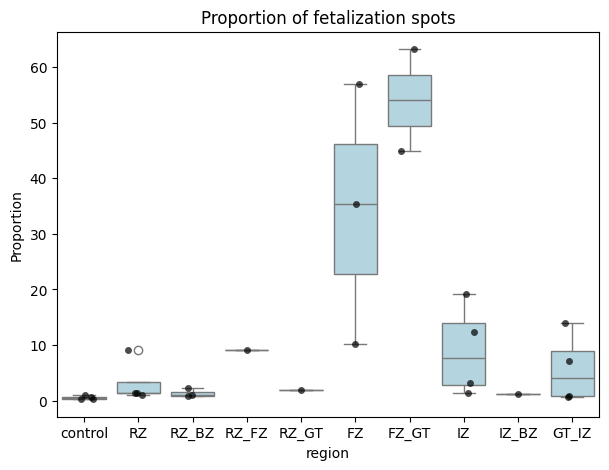

In [32]:
desired_order = ["control", "RZ", "RZ_BZ", "RZ_FZ", "RZ_GT", "FZ", "FZ_GT", "IZ", "IZ_BZ", "GT_IZ"]
plt.figure(figsize = (7, 5))
sns.boxplot(data = results_df, x = 'region', y = 'prop_fetalization_spots', color = 'lightblue', order=desired_order)
sns.stripplot(data = results_df, x='region', y='prop_fetalization_spots', color='black', order=desired_order, 
              jitter=0.2, size=5, alpha=0.7)
plt.title("Proportion of fetalization spots")
plt.xlabel("region")
plt.ylabel("Proportion")

Text(0, 0.5, 'Moran I for fetalization genes')

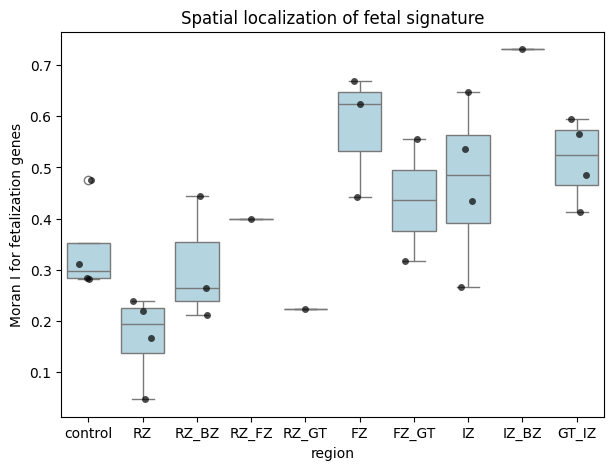

In [33]:
desired_order = ["control", "RZ", "RZ_BZ", "RZ_FZ", "RZ_GT", "FZ", "FZ_GT", "IZ", "IZ_BZ", "GT_IZ"]
plt.figure(figsize = (7, 5))
sns.boxplot(data = results_df, x = 'region', y = 'fetal_Moran', color = 'lightblue', order=desired_order)
sns.stripplot(data = results_df, x='region', y='fetal_Moran', color='black', order=desired_order, 
              jitter=0.2, size=5, alpha=0.7)
plt.title("Spatial localization of fetal signature")
plt.xlabel("region")
plt.ylabel("Moran I for fetalization genes")
#plt.savefig("../../../../paper_figures/Moran_I_for_fetalization_Kuppe.pdf")

### Calculate statistical significance

In [34]:
from scipy.stats import mannwhitneyu

ND_regions = ["control", "RZ", "RZ_BZ", "RZ_FZ", "RZ_GT"]
D_regions = ["FZ", "FZ_GT", "IZ", "IZ_BZ", "GT_IZ"]

ND_values = results_df[results_df["region"].isin(ND_regions)]["fetal_Moran"]
D_values = results_df[results_df["region"].isin(D_regions)]["fetal_Moran"]

stat, p_value = mannwhitneyu(ND_values, D_values, alternative="two-sided") 

print(f"p value is: {p_value}")

p value is: 0.0002485736861677848


In [35]:
ND_regions = ["control", "RZ", "RZ_BZ", "RZ_FZ", "RZ_GT"]
D_regions = ["FZ", "FZ_GT", "IZ", "IZ_BZ", "GT_IZ"]

ND_values = results_df[results_df["region"].isin(ND_regions)]["prop_fetalization_spots"]
D_values = results_df[results_df["region"].isin(D_regions)]["prop_fetalization_spots"]

stat, p_value = mannwhitneyu(ND_values, D_values, alternative="two-sided") 

print(f"p value is: {p_value}")

p value is: 0.0081769256522495


### Save results df

In [36]:
results_df.to_csv("Kuppe_Moran_I_results.csv")